data preprocessing

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

#normalization and augmnetation for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN,
                         CIFAR10_STD)
])

# Only normalization for validation and test
test_val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN,
                         CIFAR10_STD)
])

load the dataset

In [3]:
# Download and apply transforms
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_val_transform)

100%|██████████| 170M/170M [00:05<00:00, 30.6MB/s]


splitting the dataset into training and validation

In [4]:
train_size = int(0.8 * len(full_train_dataset))  # 80% train
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# override to remove augmentation transformation on validation dataset
val_dataset.dataset.transform = test_val_transform

data loaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

training the model

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_model(model, train_loader, val_loader, test_loader, optimizer):
  criterion=nn.CrossEntropyLoss()

  #train the dataset
  num_epochs=10
  for epoch in range(num_epochs):
    model.train()
    train_loss=0.0
    train_correct=0
    train_total=0
    for images, labels in train_loader:
      images, labels=images.to(device), labels.to(device)
      outputs=model(images)

      #calculating loss (crossentropy has inbuilt softmax function)
      loss=criterion(outputs, labels)

      #clears old gradient, and prevents adding up of gradients
      optimizer.zero_grad()

      #computes gradient of the loss by backpropagation
      loss.backward()

      #optimizer updates the weights and biases using the gradients, to minimize loss
      optimizer.step()

      #sums the batch loss in each epoch
      train_loss+=loss.item()
      #.item() converts the tensor to python float
      _,preds=torch.max(outputs, 1)
      train_correct+=(preds==labels).sum().item()
      train_total+=labels.size(0)
    #validation
    model.eval()
    val_loss=0.0
    correct=0
    total=0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels=images.to(device), labels.to(device)
        outputs=model(images)

        loss=criterion(outputs, labels)
        val_loss+=loss.item()

        #outputs dimension is [batch_size, num_classes], so predicted gets the class index with highest score
        _,predicted=torch.max(outputs, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {100 * train_correct/train_total:.2f}%")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {100 * correct / total:.2f}%")

  #final evaluation

  all_test_preds=[]
  all_test_labels=[]
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          all_test_preds.extend(predicted.cpu().numpy())
          all_test_labels.extend(labels.cpu().numpy())
          correct += (predicted == labels).sum().item()
  print()
  print(f"Test Accuracy: {100 * correct / total:.2f}%")
  print()

  cm = confusion_matrix(all_test_labels, all_test_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=[f"Class {i}" for i in range(10)],
              yticklabels=[f"Class {i}" for i in range(10)])
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.show()


fine tuning resnet-152

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]
Train Loss: 0.9309, Train Acc: 68.06%
Val Loss: 0.5825, Val Acc: 80.31%
Epoch [2/10]
Train Loss: 0.4710, Train Acc: 84.02%
Val Loss: 0.5260, Val Acc: 81.67%
Epoch [3/10]
Train Loss: 0.3140, Train Acc: 89.29%
Val Loss: 0.5938, Val Acc: 80.09%
Epoch [4/10]
Train Loss: 0.2382, Train Acc: 92.00%
Val Loss: 0.6415, Val Acc: 82.58%
Epoch [5/10]
Train Loss: 0.1729, Train Acc: 94.46%
Val Loss: 0.6007, Val Acc: 82.34%
Epoch [6/10]
Train Loss: 0.2319, Train Acc: 93.18%
Val Loss: 0.6094, Val Acc: 81.66%
Epoch [7/10]
Train Loss: 0.1619, Train Acc: 94.81%
Val Loss: 0.6160, Val Acc: 84.42%
Epoch [8/10]
Train Loss: 0.0771, Train Acc: 97.57%
Val Loss: 0.6961, Val Acc: 82.76%
Epoch [9/10]
Train Loss: 0.1073, Train Acc: 96.75%
Val Loss: 0.6728, Val Acc: 82.76%
Epoch [10/10]
Train Loss: 0.1092, Train Acc: 96.47%
Val Loss: 0.6827, Val Acc: 84.25%

Test Accuracy: 83.43%



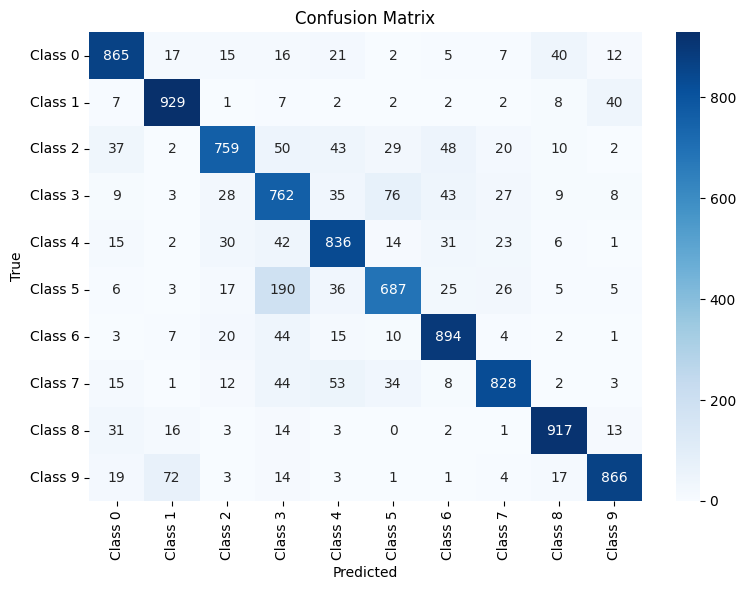

In [10]:
import torchvision.models as models

model=models.resnet152(pretrained=True)

# Modify the last layer of the model
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 0.001},         # Final layer — new
    {'params': [param for name, param in model.named_parameters() if "fc" not in name], 'lr': 0.0001}  # Rest — pretrained
])

model.to(device)
train_model(model, train_loader, val_loader, test_loader, optimizer)

Epoch [1/10]
Train Loss: 1.6777, Train Acc: 40.83%
Val Loss: 1.5530, Val Acc: 45.54%
Epoch [2/10]
Train Loss: 1.4565, Train Acc: 49.02%
Val Loss: 1.4657, Val Acc: 48.59%
Epoch [3/10]
Train Loss: 1.3470, Train Acc: 52.94%
Val Loss: 1.4345, Val Acc: 49.70%
Epoch [4/10]
Train Loss: 1.2600, Train Acc: 56.12%
Val Loss: 1.3802, Val Acc: 51.78%
Epoch [5/10]
Train Loss: 1.1854, Train Acc: 58.94%
Val Loss: 1.3694, Val Acc: 52.01%
Epoch [6/10]
Train Loss: 1.1164, Train Acc: 61.56%
Val Loss: 1.3447, Val Acc: 53.05%
Epoch [7/10]
Train Loss: 1.0552, Train Acc: 63.94%
Val Loss: 1.3774, Val Acc: 52.54%
Epoch [8/10]
Train Loss: 0.9943, Train Acc: 65.76%
Val Loss: 1.3533, Val Acc: 53.39%
Epoch [9/10]
Train Loss: 0.9360, Train Acc: 68.28%
Val Loss: 1.3600, Val Acc: 53.67%
Epoch [10/10]
Train Loss: 0.8779, Train Acc: 70.22%
Val Loss: 1.3808, Val Acc: 53.21%

Test Accuracy: 53.34%



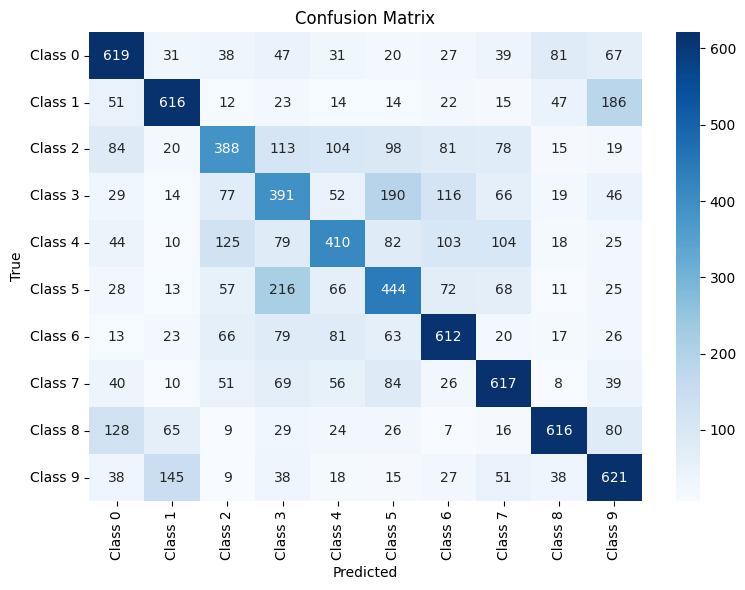

In [11]:
model=nn.Sequential(nn.Flatten(),
    nn.Linear(3*32*32, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)
optimizer=optim.Adam(model.parameters(), lr=0.0001)
train_model(model, train_loader, val_loader, test_loader, optimizer)